<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_TL2_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Transfer Learning Fine-tuning

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import random
import os

from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.layers import Rescaling # Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.
from tensorflow.keras.layers import RandomFlip, RandomHeight, RandomRotation, RandomWidth, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [3]:
SEMENTE = 2008193

DIR_TREINO    = '10_food_classes_all_data/train'
DIR_TREINO_10 = '10_food_classes_10_percent/train'
DIR_TREINO_1  = '10_food_classes_1_percent/train'
DIR_TESTE     = '10_food_classes_all_data/test'

TAMANHO_LOTE = 32
FORMATO_IMAGEM = (224, 224)
MODO_CLASSE = 'categorical'

FORMATO_ENTRADA = FORMATO_IMAGEM + (3,)
ATIVACAO = 'softmax'

PERDA = 'categorical_crossentropy'
METRICAS = ['accuracy']

# OTIMIZADOR = 'Adam'
# APRENDIZADO = 0.001

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-23 20:19:12--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4049 (4.0K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   3.95K  --.-KB/s    in 0s      

2023-01-23 20:19:12 (47.9 MB/s) - ‘funcoes.py’ saved [4049/4049]



In [5]:
from funcoes import criar_callback_tensorboard, grafico_perda_precisao_por_iteracao, unzip_data, walk_through_dir

## Dados

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_all_data.zip')
unzip_data('10_food_classes_10_percent.zip')
unzip_data('10_food_classes_1_percent.zip')

--2023-01-23 20:19:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  41.2MB/s    in 13s     

2023-01-23 20:19:25 (38.7 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

--2023-01-23 20:19:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK

In [7]:
# walk_through_dir('10_food_classes_all_data')

### Importando os dados e tranformando-os em lotes

In [8]:
dados_treino = image_dataset_from_directory(directory=DIR_TREINO,
                                            batch_size=TAMANHO_LOTE,
                                            image_size=FORMATO_IMAGEM,
                                            label_mode=MODO_CLASSE,
                                            seed=SEMENTE)

dados_teste = image_dataset_from_directory(directory=DIR_TESTE,
                                           batch_size=TAMANHO_LOTE,
                                           image_size=FORMATO_IMAGEM,
                                           label_mode=MODO_CLASSE,
                                           seed=SEMENTE)

dados_treino_10 = image_dataset_from_directory(directory=DIR_TREINO_10,
                                               batch_size=TAMANHO_LOTE,
                                               image_size=FORMATO_IMAGEM,
                                               label_mode=MODO_CLASSE,
                                               seed=SEMENTE)

dados_treino_1 = image_dataset_from_directory(directory=DIR_TREINO_1,
                                              batch_size=TAMANHO_LOTE,
                                              image_size=FORMATO_IMAGEM,
                                              label_mode=MODO_CLASSE,
                                              seed=SEMENTE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 70 files belonging to 10 classes.


In [9]:
# image_dataset_from_directory retorna um BatchDataset

# O primeiro tensor contém as imagens. DADOS NÃO ESCALONADOS.
# O tamanho do lote não está especificado, mesmo que tenha sido informado.
# Os canais de cores estão definidos pelo parâmetro color_mode='rgb' (default).

# O segundo tensor contém as classes em formato one-hot.

dados_treino

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
rotulos = dados_treino.class_names
# rotulos

## Criando Modelo_00

The Functional API: https://www.tensorflow.org/guide/keras/functional

Modelos pré-treinados: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [12]:
# Criar um modelo-base a partir de um modelo pré-treinado.
# EfficientNetB0 foi treinado com a ImageNet, portanto a camada no topo tem 1000 entradas.
# Nossos dados possuem 10 classes, portanto não utilizaremos a camada no topo padrão. (include_top=False)
modelo_base = EfficientNetB0(include_top=False)

# "Congelar" o modelo-base, para que os padrões pré-treinados não sejam odificados durante o treinamento.
modelo_base.trainable = False

# Camada de entrada.
entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

# Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.
# Modelos EfficientNet possuem escalonamento interno.
# camadas = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(entradas)
# Obs.: acredito que a camada de escalonamento devia ser adicionada à 'entradas', não 'camadas'.

# Carregar as entradas no modelo-base.
camadas = modelo_base(entradas)

# Agrupar a média global do modelo-base.
# Esta camada cria o vetor de características (feature vector).
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

# Camada de saída.
saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

# Reunir camadas de entrada e saída em um modelo.
modelo_00 = Model(inputs=entradas, outputs=saidas, name='Modelo_00')

# Compilar o modelo.
modelo_00.compile(loss=PERDA, optimizer=Adam(), metrics=METRICAS)

# Ajustar o modelo, gravando histórico e criando logs TensorBoard.
historico_00 = modelo_00.fit(dados_treino_10,
                             epochs=5,
                             steps_per_epoch=len(dados_treino_10),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_00_10_por_cento')],
                             verbose=1)

16705208/16705208 [==============================] - 1s 0us/step
Salvando log TensorBoard em: 'transfer_learning/modelo_00_10_por_cento/20230123-162242'.
Epoch 1/5
24/24 [==============================] - 22s 403ms/step - loss: 1.9361 - accuracy: 0.3920 - val_loss: 1.3319 - val_accuracy: 0.7224
Epoch 2/5
24/24 [==============================] - 8s 314ms/step - loss: 1.1183 - accuracy: 0.7813 - val_loss: 0.8901 - val_accuracy: 0.8088
Epoch 3/5
24/24 [==============================] - 8s 313ms/step - loss: 0.8023 - accuracy: 0.8187 - val_loss: 0.7049 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 8s 313ms/step - loss: 0.6514 - accuracy: 0.8533 - val_loss: 0.6175 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 12s 519ms/step - loss: 0.5586 - accuracy: 0.8733 - val_loss: 0.5604 - val_accuracy: 0.8596


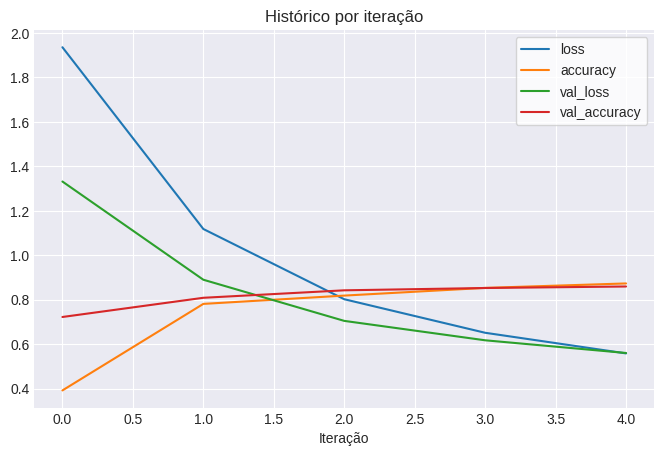

In [13]:
grafico_perda_precisao_por_iteracao(historico_00)

In [14]:
modelo_00.summary()

Model: "Modelo_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_entrada (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 agrupamento_media_global (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 camada_saida (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation 
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentaton 
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation 

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Criando Modelo_01

### Expandindo dados

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers 

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of imges (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [11]:
expansao_dados = Sequential()

# expansao_dados.add(Rescaling(1./255)) # Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.

expansao_dados.add(RandomFlip('horizontal'))
expansao_dados.add(RandomRotation(0.2))
expansao_dados.add(RandomZoom(0.2))
expansao_dados.add(RandomHeight(0.2))
expansao_dados.add(RandomWidth(0.2))

#### Visualizando dados expandidos

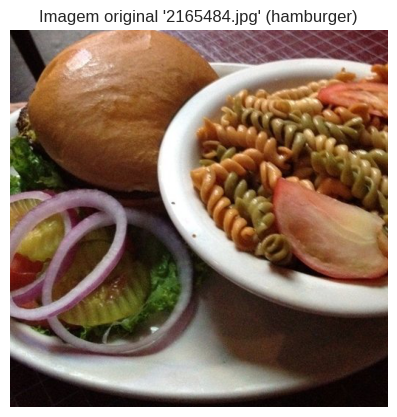

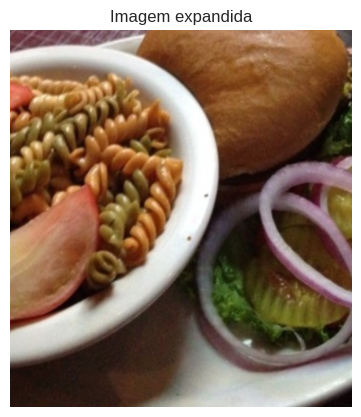

In [16]:
# classe_aleatoria = random.choice(rotulos)
# caminho_classe   = DIR_TREINO_1 + '/' + classe_aleatoria
# imagem_aleatoria = random.choice(os.listdir(caminho_classe))
# caminho_imagem   = caminho_classe + '/' + imagem_aleatoria

# imagem = mpimg.imread(caminho_imagem)

# # imagem_expandida = expansao_dados(tf.expand_dims(imagem, axis=0))
# # Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
# imagem_expandida = expansao_dados(tf.expand_dims(imagem, axis=0), training=True)

# plt.title(f"Imagem original '{imagem_aleatoria}' ({classe_aleatoria})")
# plt.imshow(imagem)
# plt.axis(False)
# plt.show()

# plt.title(f"Imagem expandida")
# # plt.imshow(tf.squeeze(imagem_expandida))
# plt.imshow(tf.divide(tf.squeeze(imagem_expandida), 255.)) # Escalonamento para visualização
# plt.axis(False)
# plt.show()

### Modelo

Sobre `training=False` ao carregar os dados no `modelo_base`.

We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.

https://keras.io/guides/transfer_learning/#build-a-model

In [22]:
modelo_base = EfficientNetB0(include_top=False)
modelo_base.trainable = False

entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

# Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
expandidos = expansao_dados(entradas, training=True)

camadas = modelo_base(expandidos, training=False)
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

modelo_01 = Model(inputs=entradas, outputs=saidas, name='Modelo_01')

modelo_01.compile(loss=PERDA, optimizer=Adam(), metrics=METRICAS)

historico_01 = modelo_01.fit(dados_treino_1,
                             epochs=5,
                             steps_per_epoch=len(dados_treino_1),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_01_1_por_cento_expandido')],
                             verbose=1)

Salvando log TensorBoard em: 'transfer_learning/modelo_01_1_por_cento_expandido/20230123-164544'.
Epoch 1/5
3/3 [==============================] - 37s 16s/step - loss: 2.3957 - accuracy: 0.0857 - val_loss: 2.3251 - val_accuracy: 0.1304
Epoch 2/5
3/3 [==============================] - 21s 10s/step - loss: 2.1229 - accuracy: 0.2143 - val_loss: 2.1868 - val_accuracy: 0.2032
Epoch 3/5
3/3 [==============================] - 21s 10s/step - loss: 1.8949 - accuracy: 0.4286 - val_loss: 2.0823 - val_accuracy: 0.2648
Epoch 4/5
3/3 [==============================] - 19s 10s/step - loss: 1.7502 - accuracy: 0.5714 - val_loss: 1.9824 - val_accuracy: 0.3324
Epoch 5/5
3/3 [==============================] - 20s 10s/step - loss: 1.6193 - accuracy: 0.6714 - val_loss: 1.9109 - val_accuracy: 0.3800


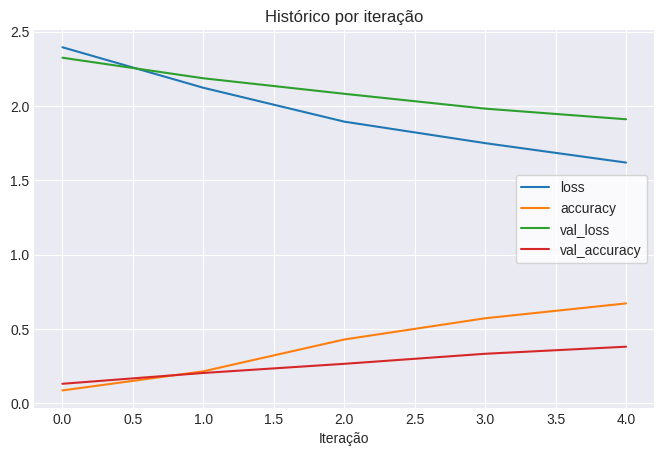

In [23]:
grafico_perda_precisao_por_iteracao(historico_01)

## Criando Modelo_02

In [12]:
modelo_base = EfficientNetB0(include_top=False)
modelo_base.trainable = False

entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

expandidos = expansao_dados(entradas, training=True)

camadas = modelo_base(expandidos, training=False)
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

modelo_02 = Model(inputs=entradas, outputs=saidas, name='Modelo_02')

modelo_02.compile(loss=PERDA, optimizer=Adam(), metrics=METRICAS)

16705208/16705208 [==============================] - 1s 0us/step


### Criando callback ModelCheckpoint

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [13]:
CAMINHO_CHECKPOINT = 'checkpoints/modelo_02'

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=CAMINHO_CHECKPOINT,  # Diretório onde os checkpoints serão salvos.
                                                         save_weights_only=True,       # Salvar somente os pesos. (Se False, todo o modelo é salvo.)
                                                         save_best_only=False,         # Salvar todos os modelos. (Se True, somente o melhor modelo é salvo.)
                                                         save_freq='epoch',            # Salvar a cada iteração
                                                         verbose=1)

### Ajustando o modelo

In [14]:
historico_02 = modelo_02.fit(dados_treino_10,
                             epochs=5,
                             steps_per_epoch=len(dados_treino_10),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_02_10_por_cento_expandido'),
                                        callback_checkpoint],
                             verbose=1)

Salvando log TensorBoard em: 'transfer_learning/modelo_02_10_por_cento_expandido/20230123-202017'.
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9470 - accuracy: 0.3627
Epoch 1: saving model to checkpoints/modelo_02
24/24 [==============================] - 264s 11s/step - loss: 1.9470 - accuracy: 0.3627 - val_loss: 1.4966 - val_accuracy: 0.6484
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2829 - accuracy: 0.6973
Epoch 2: saving model to checkpoints/modelo_02
24/24 [==============================] - 247s 11s/step - loss: 1.2829 - accuracy: 0.6973 - val_loss: 1.0971 - val_accuracy: 0.7464
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.7613
Epoch 3: saving model to checkpoints/modelo_02
24/24 [==============================] - 245s 11s/step - loss: 0.9779 - accuracy: 0.7613 - val_loss: 0.9110 - val_accuracy: 0.7804
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8246 - accuracy: 0.

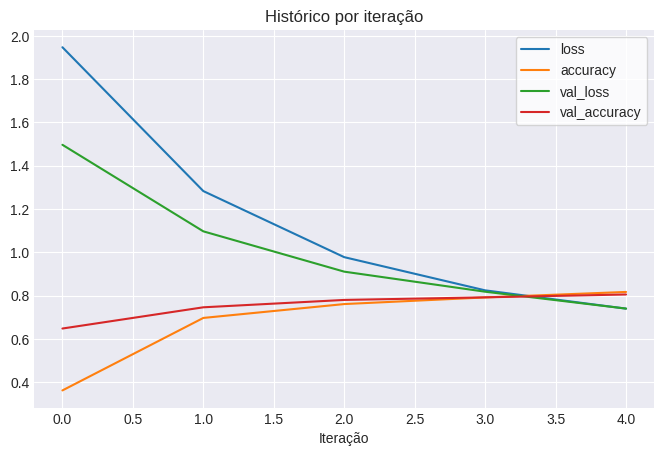

In [15]:
grafico_perda_precisao_por_iteracao(historico_02)

### Carregando os pesos salvos nos checkpoints

In [19]:
# Validação modelo_02
validacao_modelo_02_ajustado = modelo_02.evaluate(dados_teste)

79/79 [==============================] - 176s 2s/step - loss: 0.7470 - accuracy: 0.8092


In [20]:
# Carregar os pesos retorna o modelo a um checkpoint.
modelo_02.load_weights(CAMINHO_CHECKPOINT)

In [21]:
# Validação modelo_02 após carregar os pesos
validacao_modelo_02_carregado = modelo_02.evaluate(dados_teste)

79/79 [==============================] - 164s 2s/step - loss: 0.7514 - accuracy: 0.8020


In [22]:
validacao_modelo_02_ajustado == validacao_modelo_02_carregado

False

In [23]:
validacao_modelo_02_ajustado, validacao_modelo_02_carregado

([0.7470461130142212, 0.8091999888420105],
 [0.7514280080795288, 0.8019999861717224])

In [24]:
import numpy as np

np.isclose(np.array(validacao_modelo_02_ajustado), np.array(validacao_modelo_02_carregado))

array([False, False])

In [25]:
np.array(validacao_modelo_02_ajustado) - np.array(validacao_modelo_02_carregado)

array([-0.0043819,  0.0072   ])